# Endometrium analysis - clusters visualization

In [93]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import rbcde

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_primaryEpithelial_clean/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.5 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

## Load data

In [94]:
adata_original = sc.read('data/endometrium-N8-epithelial_Luzprocessing_new.h5ad')
adata_original.X.shape

(5777, 6040)

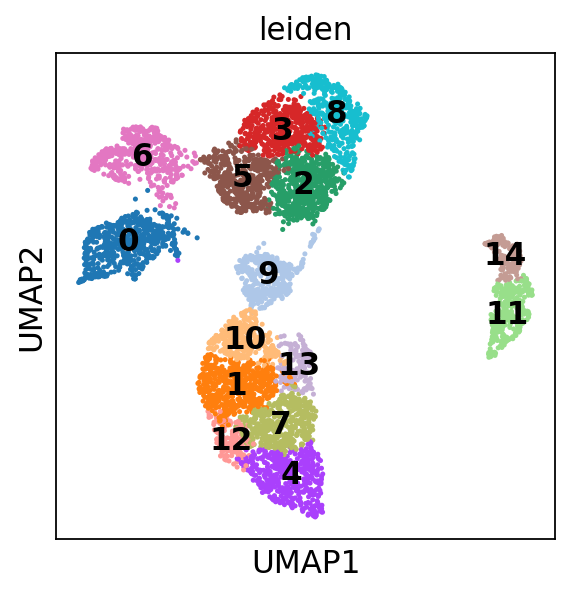

In [95]:
sc.pl.umap(adata_original, color=['leiden'], legend_loc="on data")

In [96]:
# adata_original = adata_original[[i not in ['3'] for i in adata_original.obs['leiden']]]
adata_original = adata_original[[i not in ['9', '13'] for i in adata_original.obs['leiden']]]

In [97]:
adata_original.X.shape

(5284, 6040)

## Reset object

In [98]:
adata_original.obs['leiden_v0'] = adata_original.obs['leiden']
adata = anndata.AnnData(X=np.expm1(adata_original.raw.X), var=adata_original.raw.var, obs=adata_original.obs, asview=False)

Trying to set attribute `.obs` of view, making a copy.


## Preprocess the data again

#### Filter non-expressed genes

In [99]:
sc.pp.filter_genes(adata, min_cells=5)

#### Normalize per cell

In [100]:
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

#### HVGs
These are going to be definetively different from the global annlysis. It is key to redefine these.

In [101]:
# Filter HVGs
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.25)
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

In [102]:
adata.X.shape

(5284, 5869)

#### Scale and regress out cell cycle genes

In [103]:
# Scale
sc.pp.scale(adata, max_value=10)

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [104]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/farm/gsea/raw/seurat_cellcycle/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

## PCA

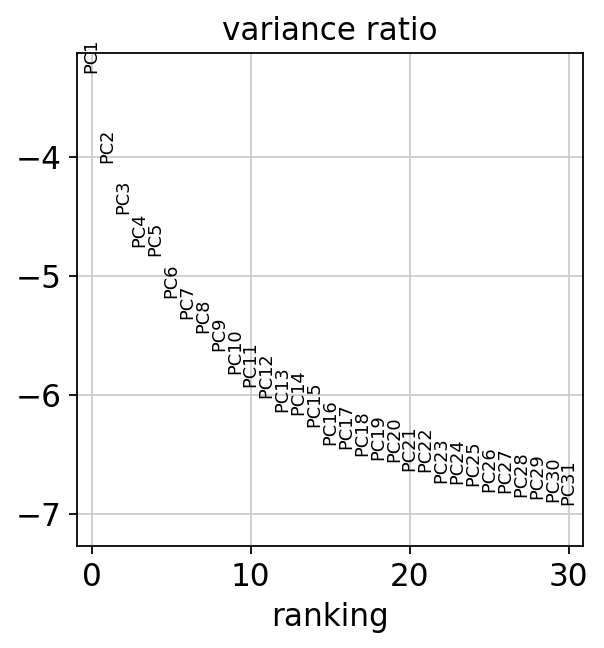

In [105]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

## Batch correction using HARMONY

In [106]:
# Extract PCA matrix and batch array
n_pcs = 5
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
batch = adata.obs['type']

In [107]:
# Batch-correct the PCA using HARMONY method
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [108]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1)
hem <- HarmonyMatrix(pca, batch, theta=1, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [109]:
# Add harmony values to the anndata object
adata.obsm['X_pca'] = hem.values

In [110]:
sc.pp.neighbors(adata, n_pcs = n_pcs, random_state=1)

In [111]:
# Visualize
sc.tl.umap(adata)

... storing 'phase' as categorical


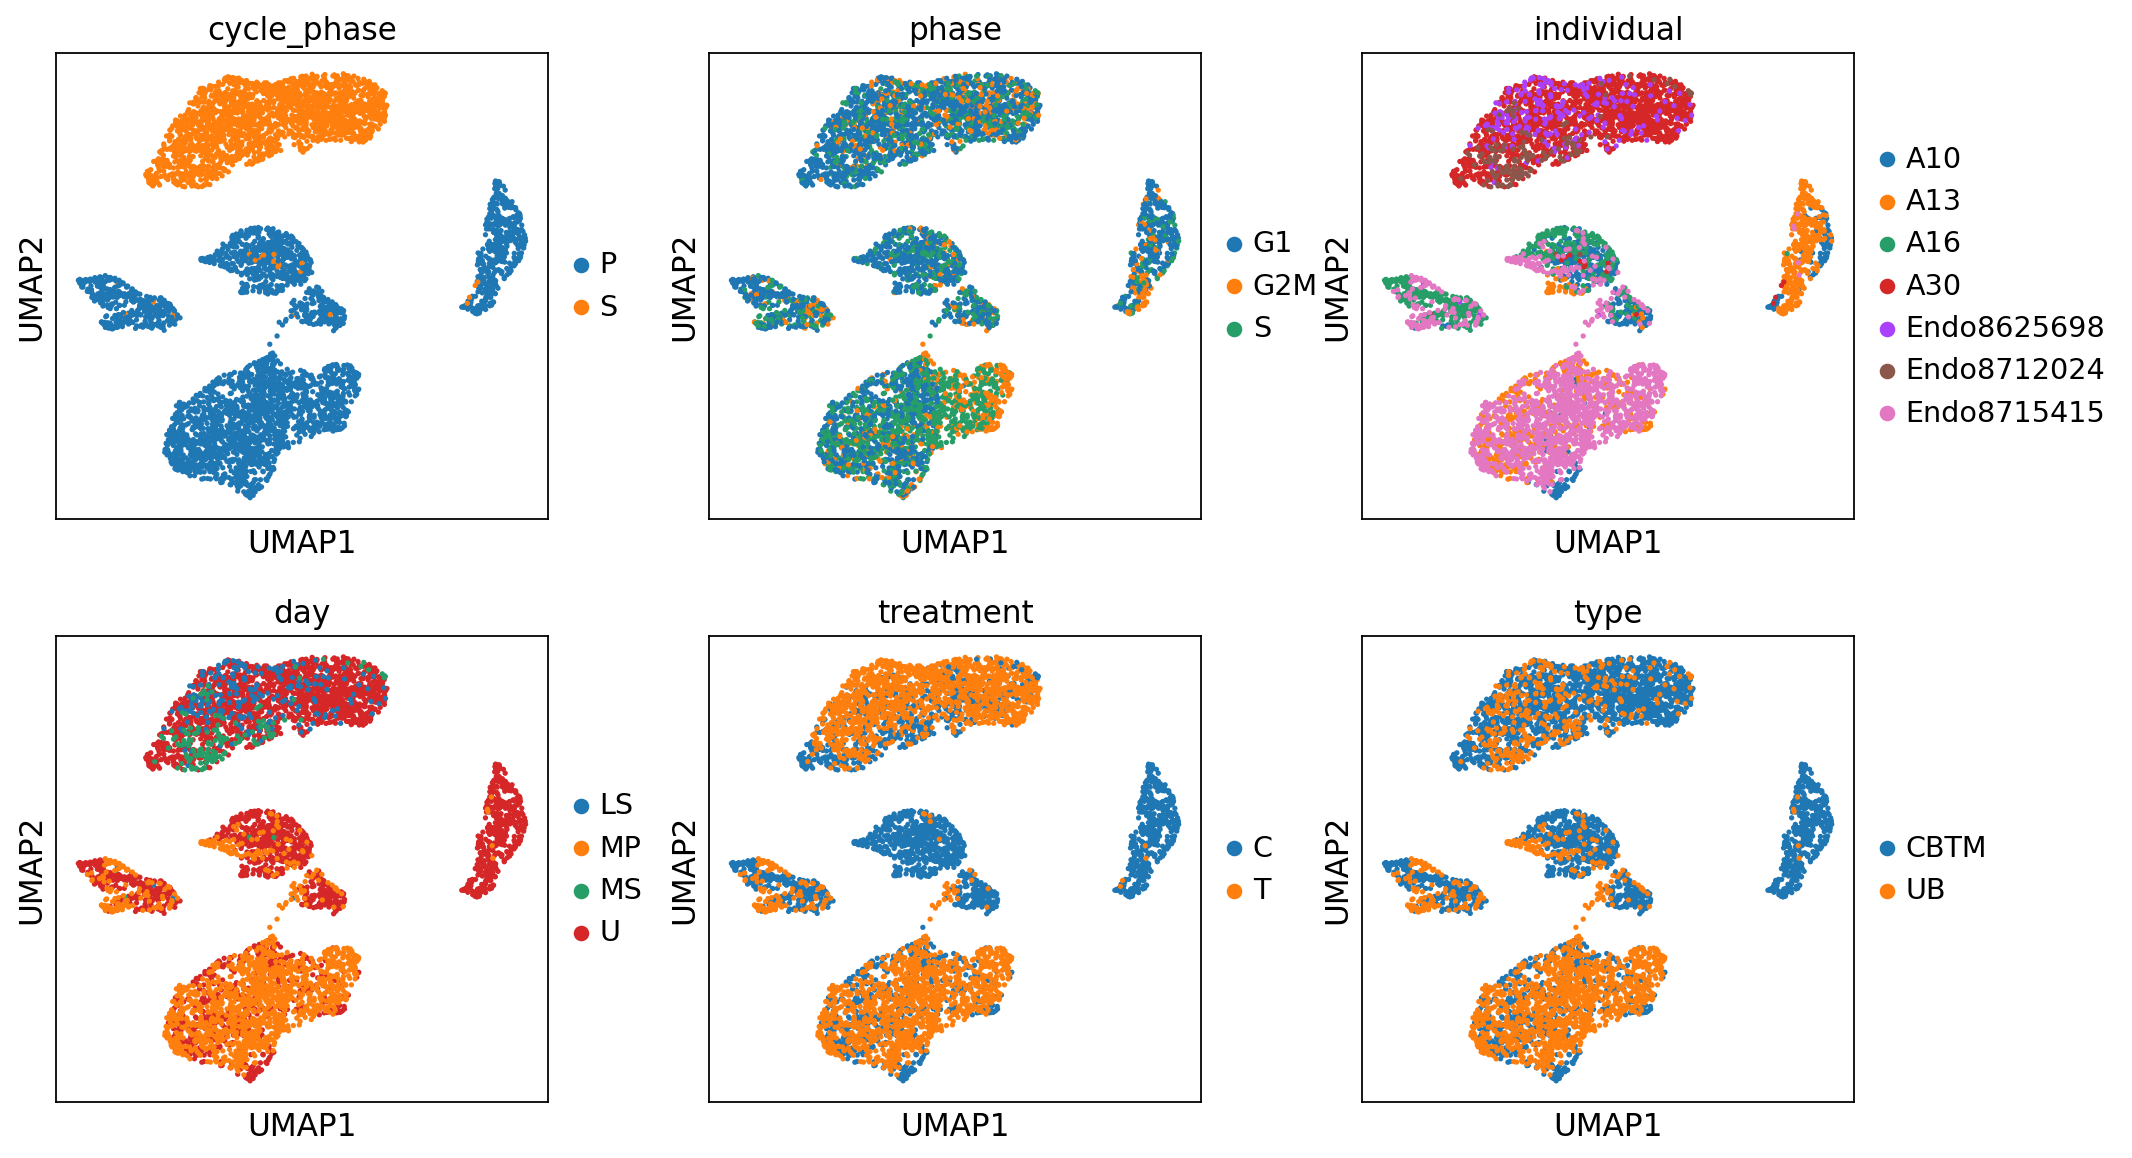

In [112]:
sc.pl.umap(adata, color=['cycle_phase', 'phase', 'individual', 'day', 'treatment', 'type'], save='.pdf', ncols = 3)

## Identify sub-clusters

In [113]:
sc.tl.leiden(adata, resolution=0.03)

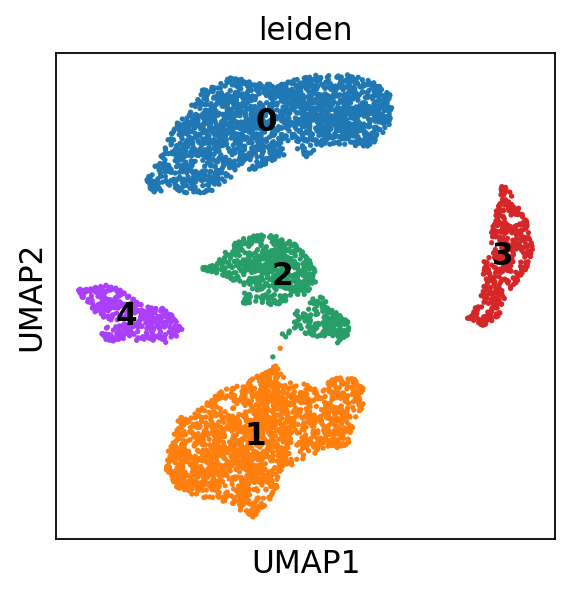

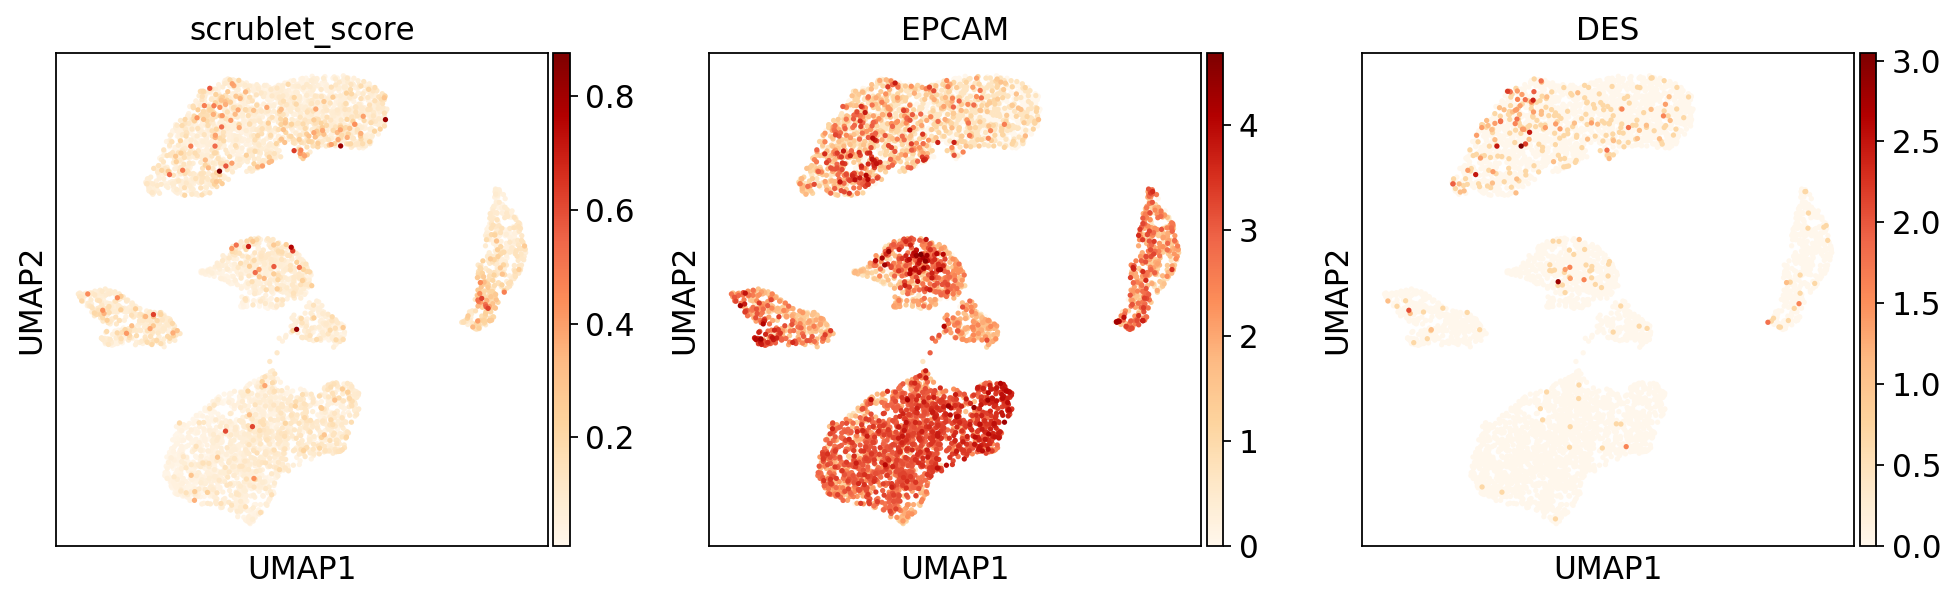

In [119]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data',save='_clustering_clusnumbers.pdf')
sc.pl.umap(adata, color=["scrublet_score", 'EPCAM', 'DES'], save='-markers_scrublet_score.pdf',color_map='OrRd') # FEMALE

In [115]:
# sc.tl.leiden(adata, resolution=0.1, restrict_to=('leiden', ['6']))
# adata.obs['leiden'].cat.categories = [str(i) for i in range(len(adata.obs['leiden'].cat.categories))]
# sc.pl.umap(adata, color=['leiden', 'leiden_v0'],legend_loc='on data',save='_clustering_clusnumbers.pdf')

In [116]:
adata2plot = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False)
sc.pp.normalize_per_cell(adata2plot, counts_per_cell_after=1e4)
sc.pp.log1p(adata2plot)
sc.pp.scale(adata2plot, max_value=10)
adata2plot.obsm['X_umap'] = adata.obsm['X_umap']

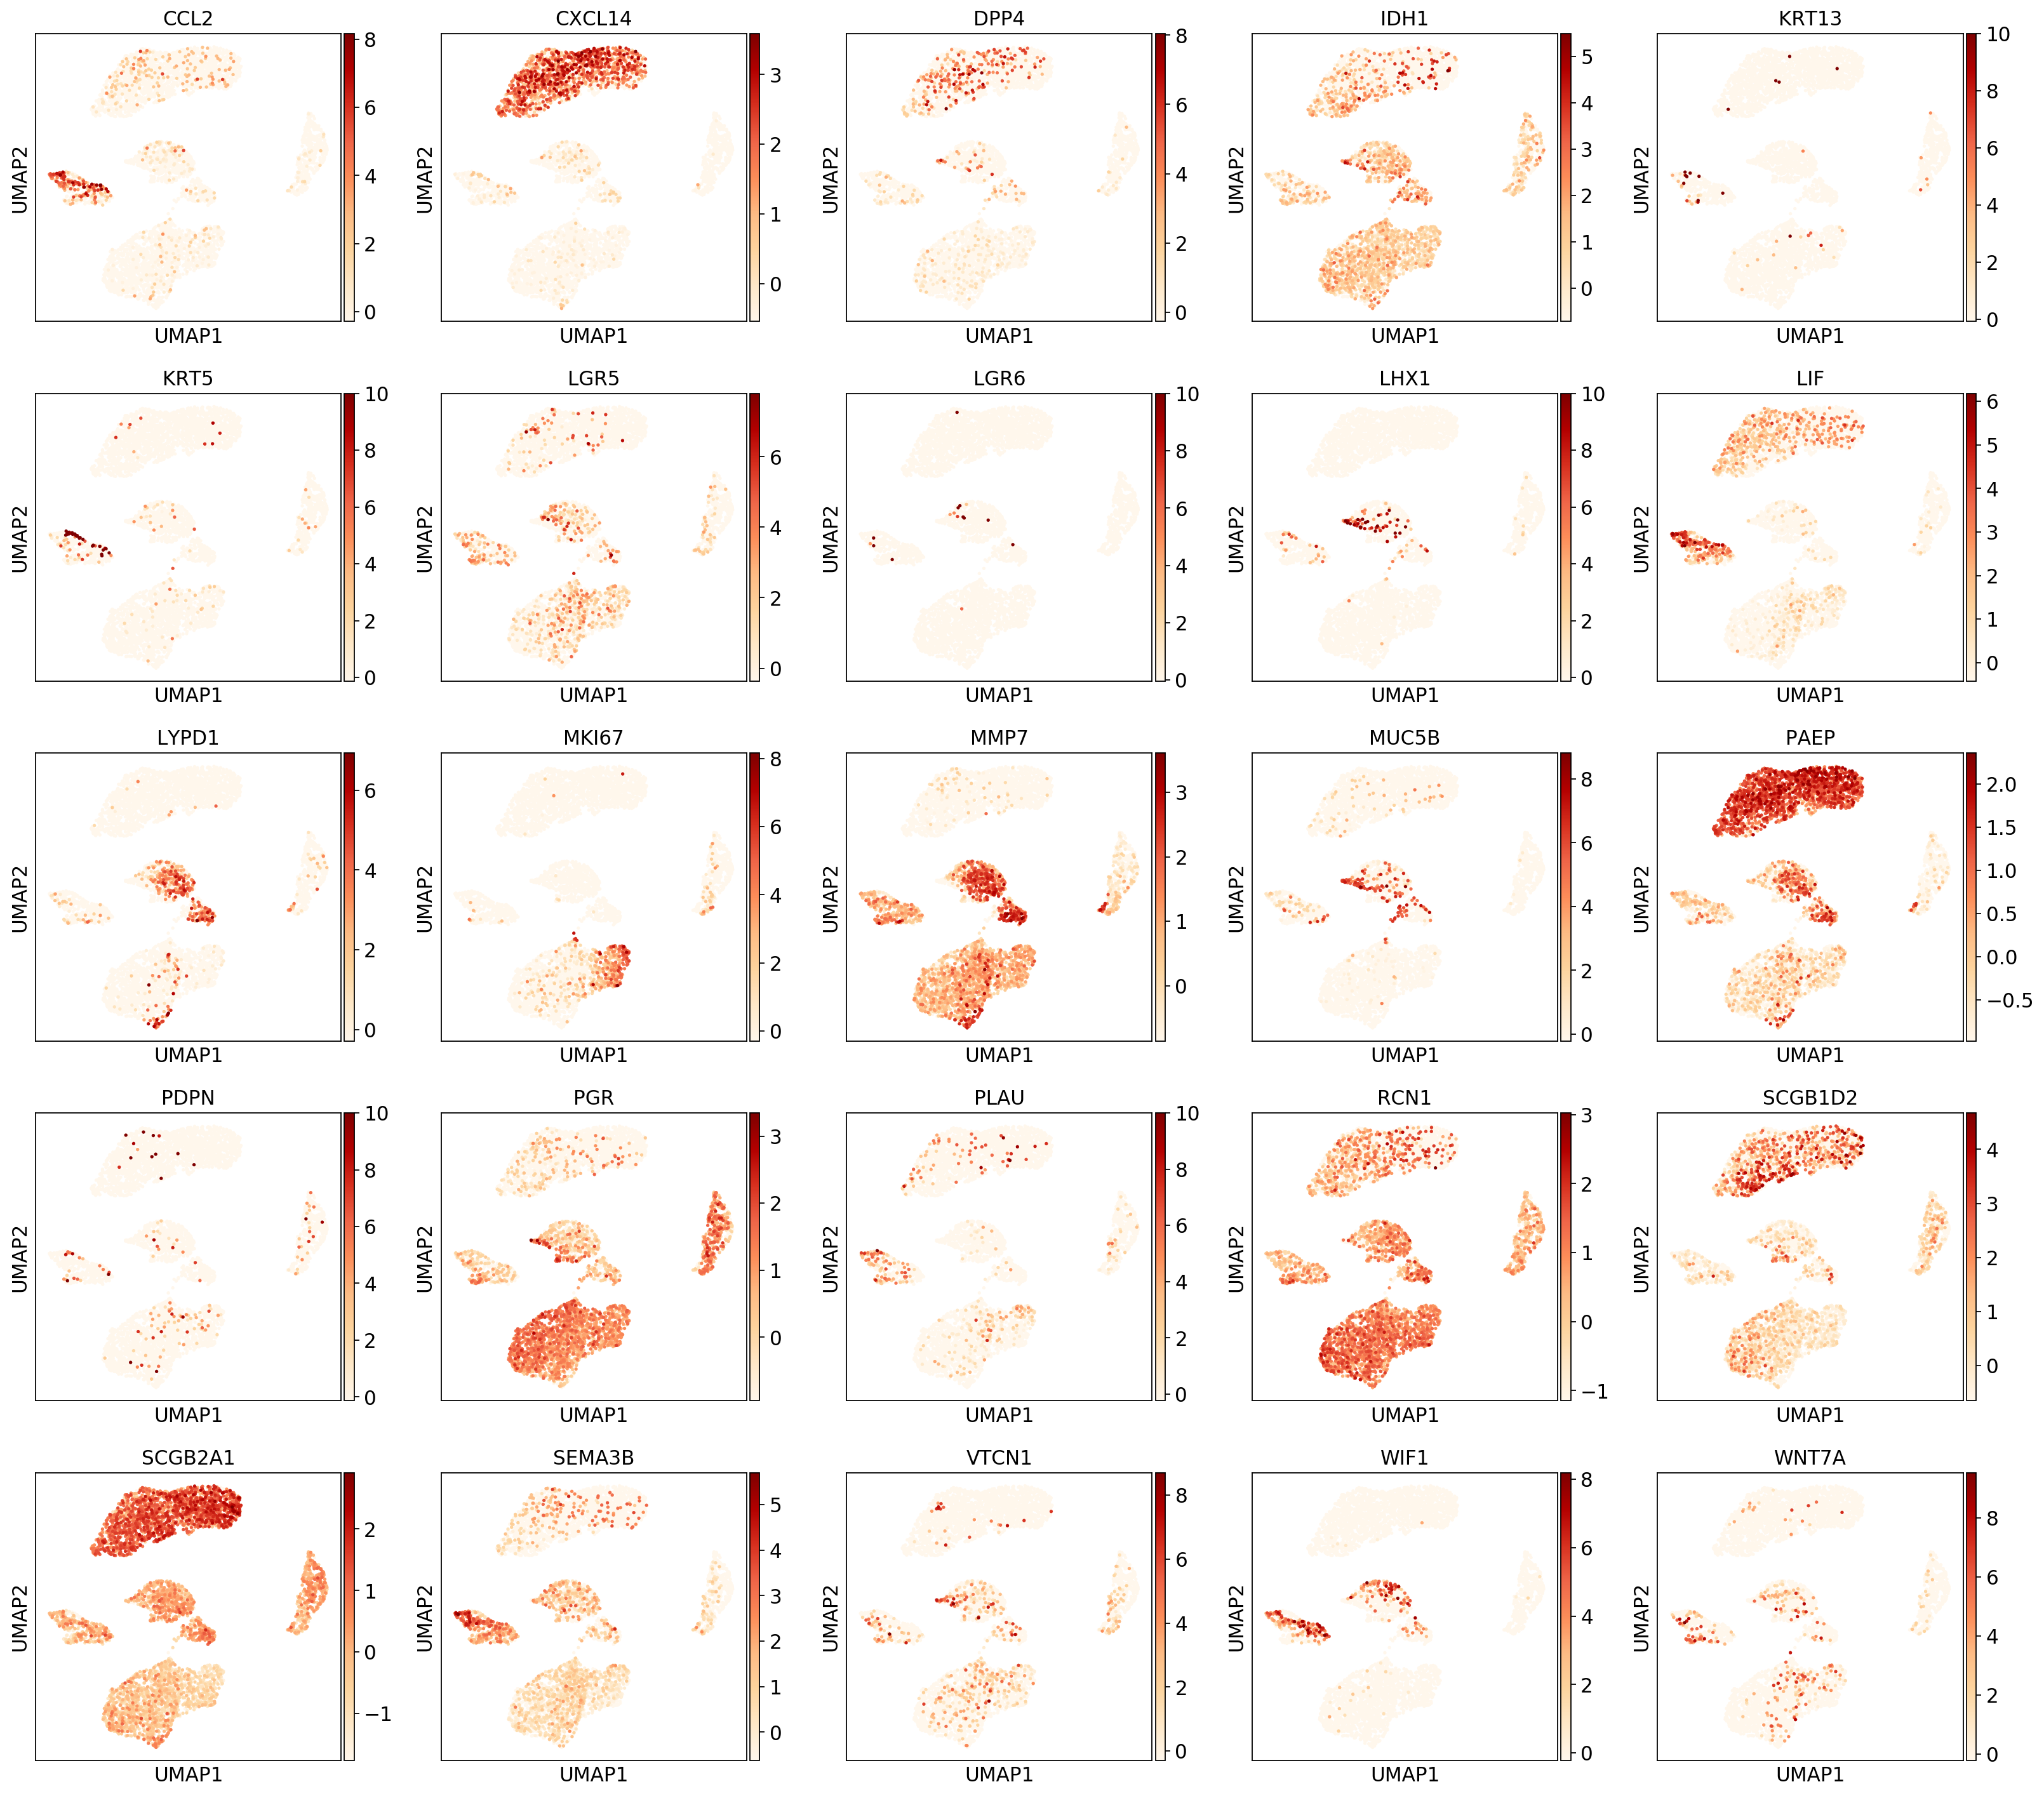

In [123]:
markers = ["LGR6", "WNT7A",  "LHX1", "KRT5", # progenitor 
                         "LGR5", "PDPN", "KRT13", "WIF1", "CCL2", "LYPD1",
                         "MMP7", 
                         "PAEP",  "DPP4", # Early Glandular
                         "SCGB1D2",# Late Glandular
                         "CXCL14", # Only secretory
                         "SEMA3B",  "MUC5B", "MKI67", "PLAU", 'PGR', "SCGB2A1", "VTCN1", "LIF", 'IDH1', 'RCN1']
markers = sorted(markers)
sc.pl.umap(adata2plot, color=markers, save='-markers_pseudotime.pdf',color_map='OrRd', ncols=5) # FEMALE

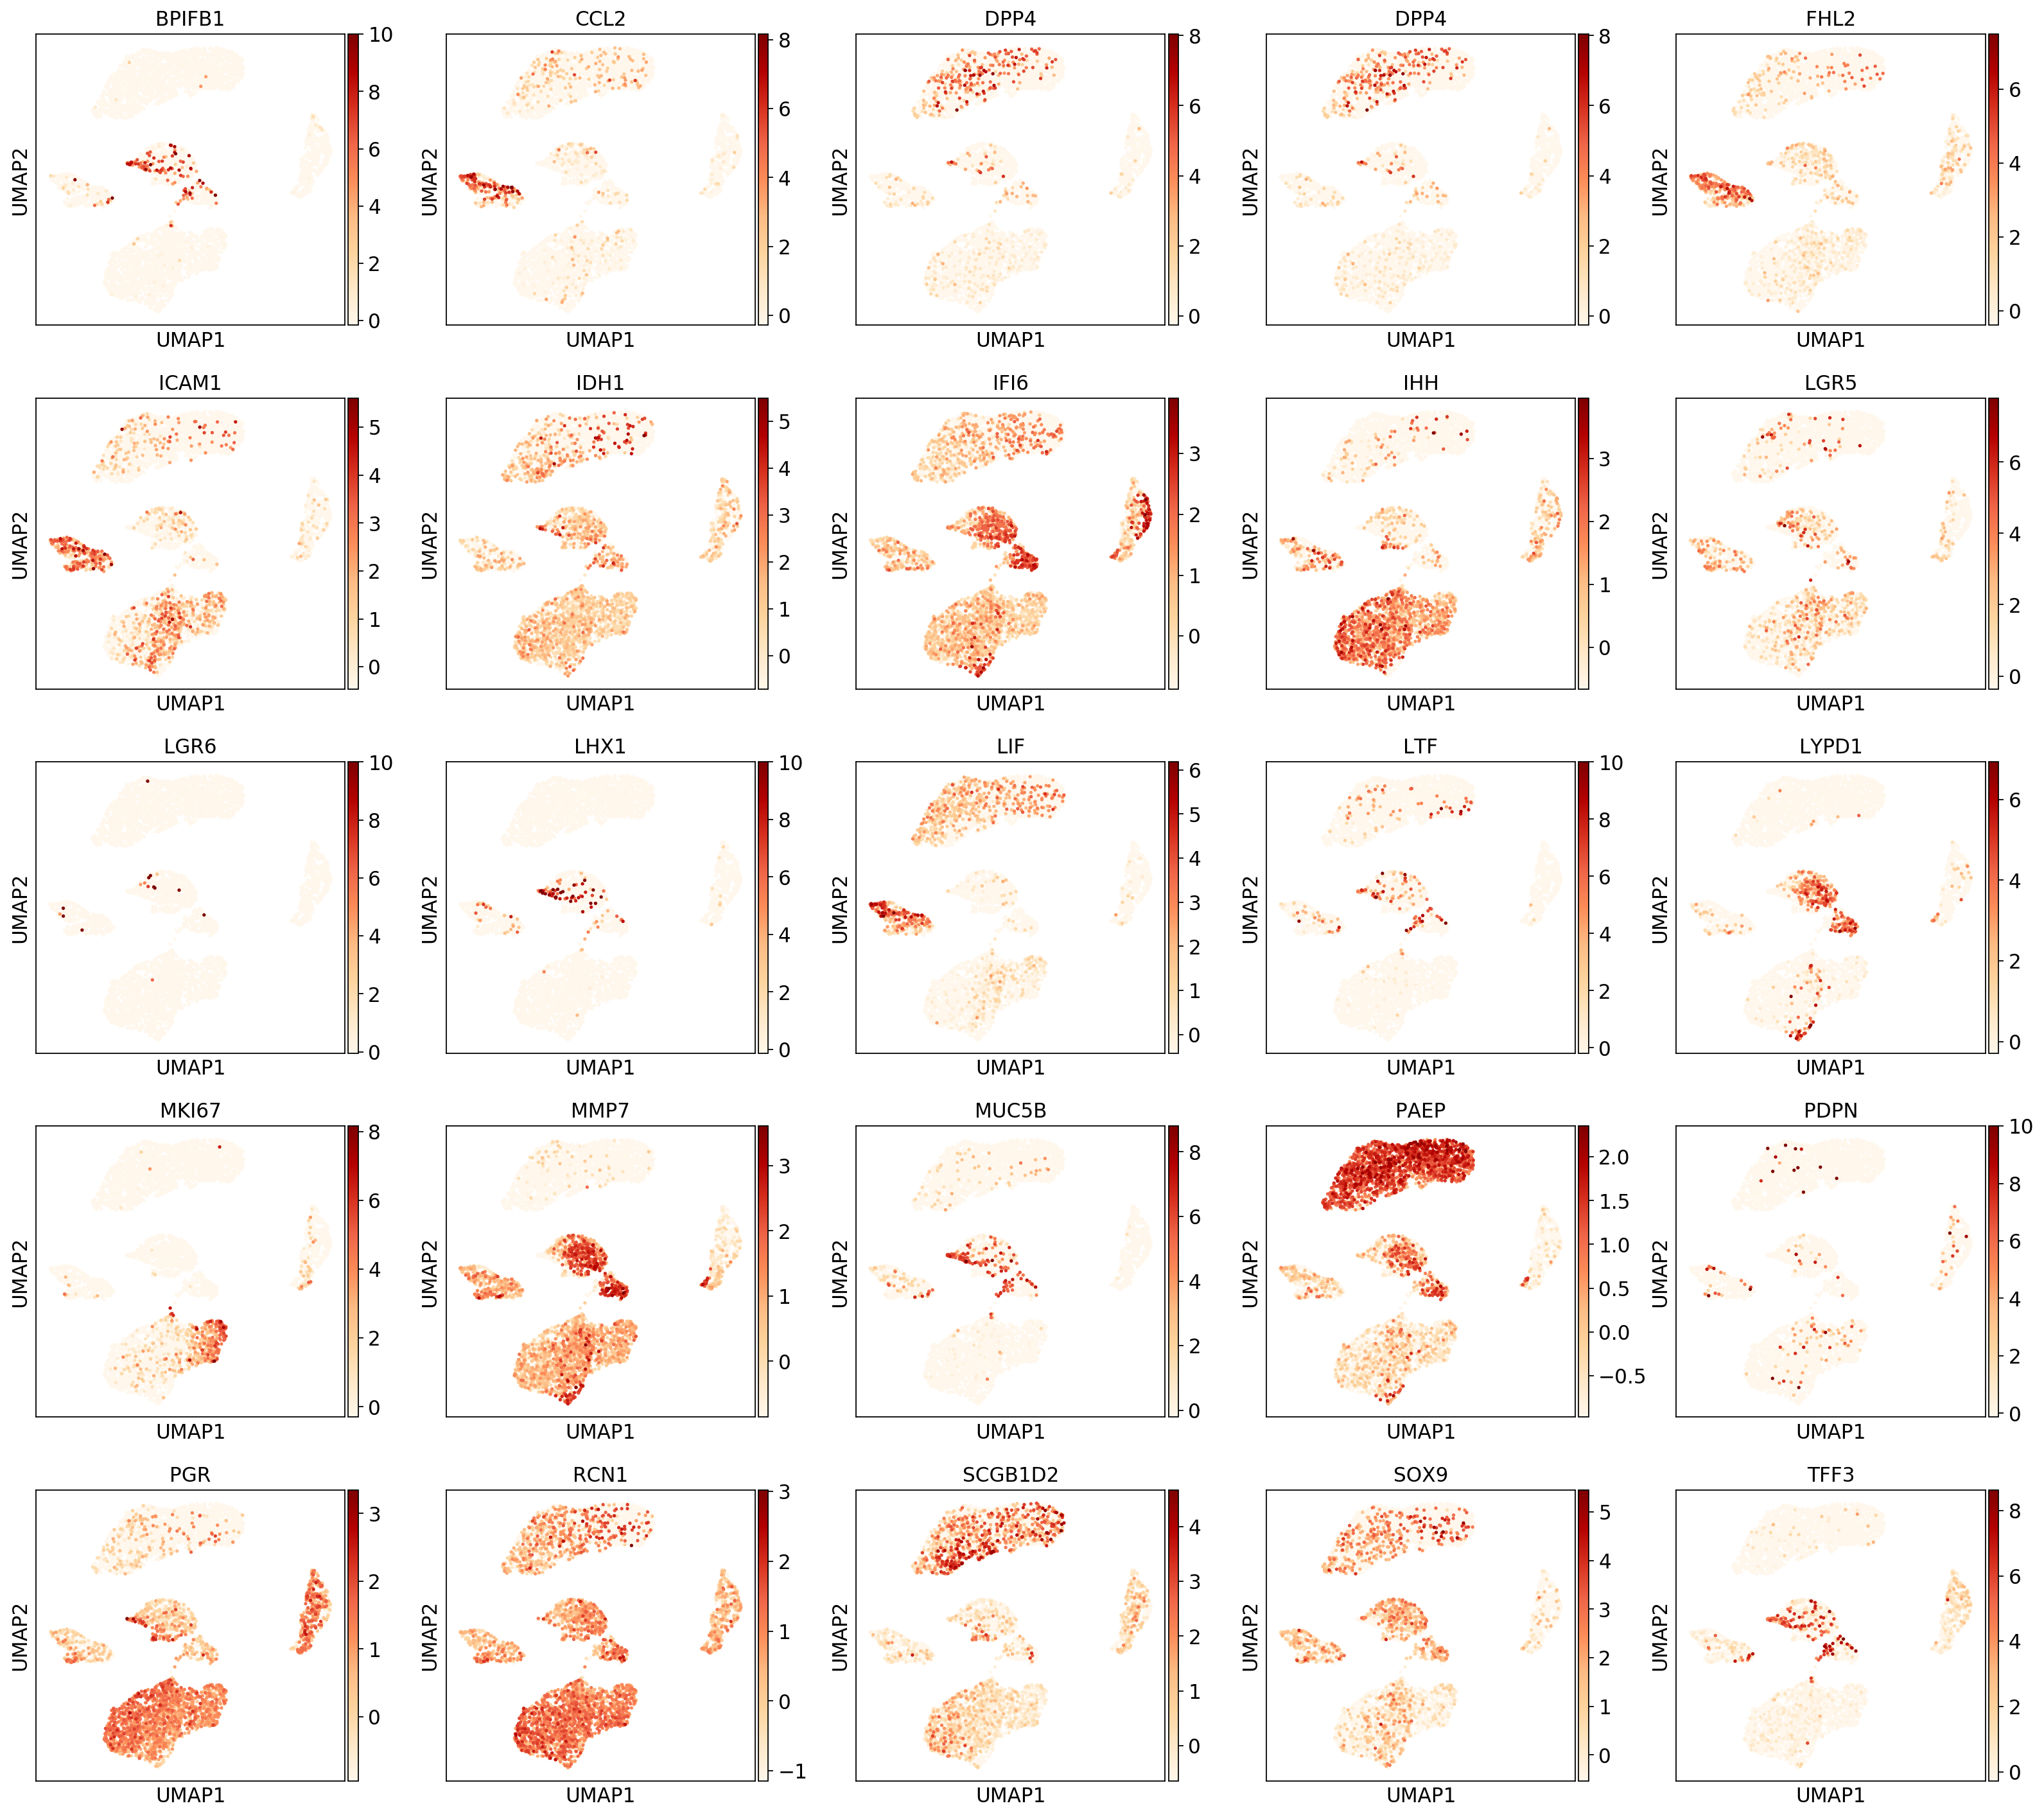

In [120]:
markers = ["SCGB1D2", "PAEP", "DPP4", "PGR", "IHH", "MKI67", "TFF3", "MUC5B", "LTF", "BPIFB1", "LHX1", "LIF", "CCL2", "FHL2", "ICAM1", "MMP7", "IFI6", "LYPD1", "IDH1", "RCN1", "SOX9", "LGR5", "LGR6", "PDPN", "DPP4"]
markers = sorted(markers)
sc.pl.umap(adata2plot, color=markers, save='-markers_clusters.pdf',color_map='OrRd', ncols=5) # FEMALE

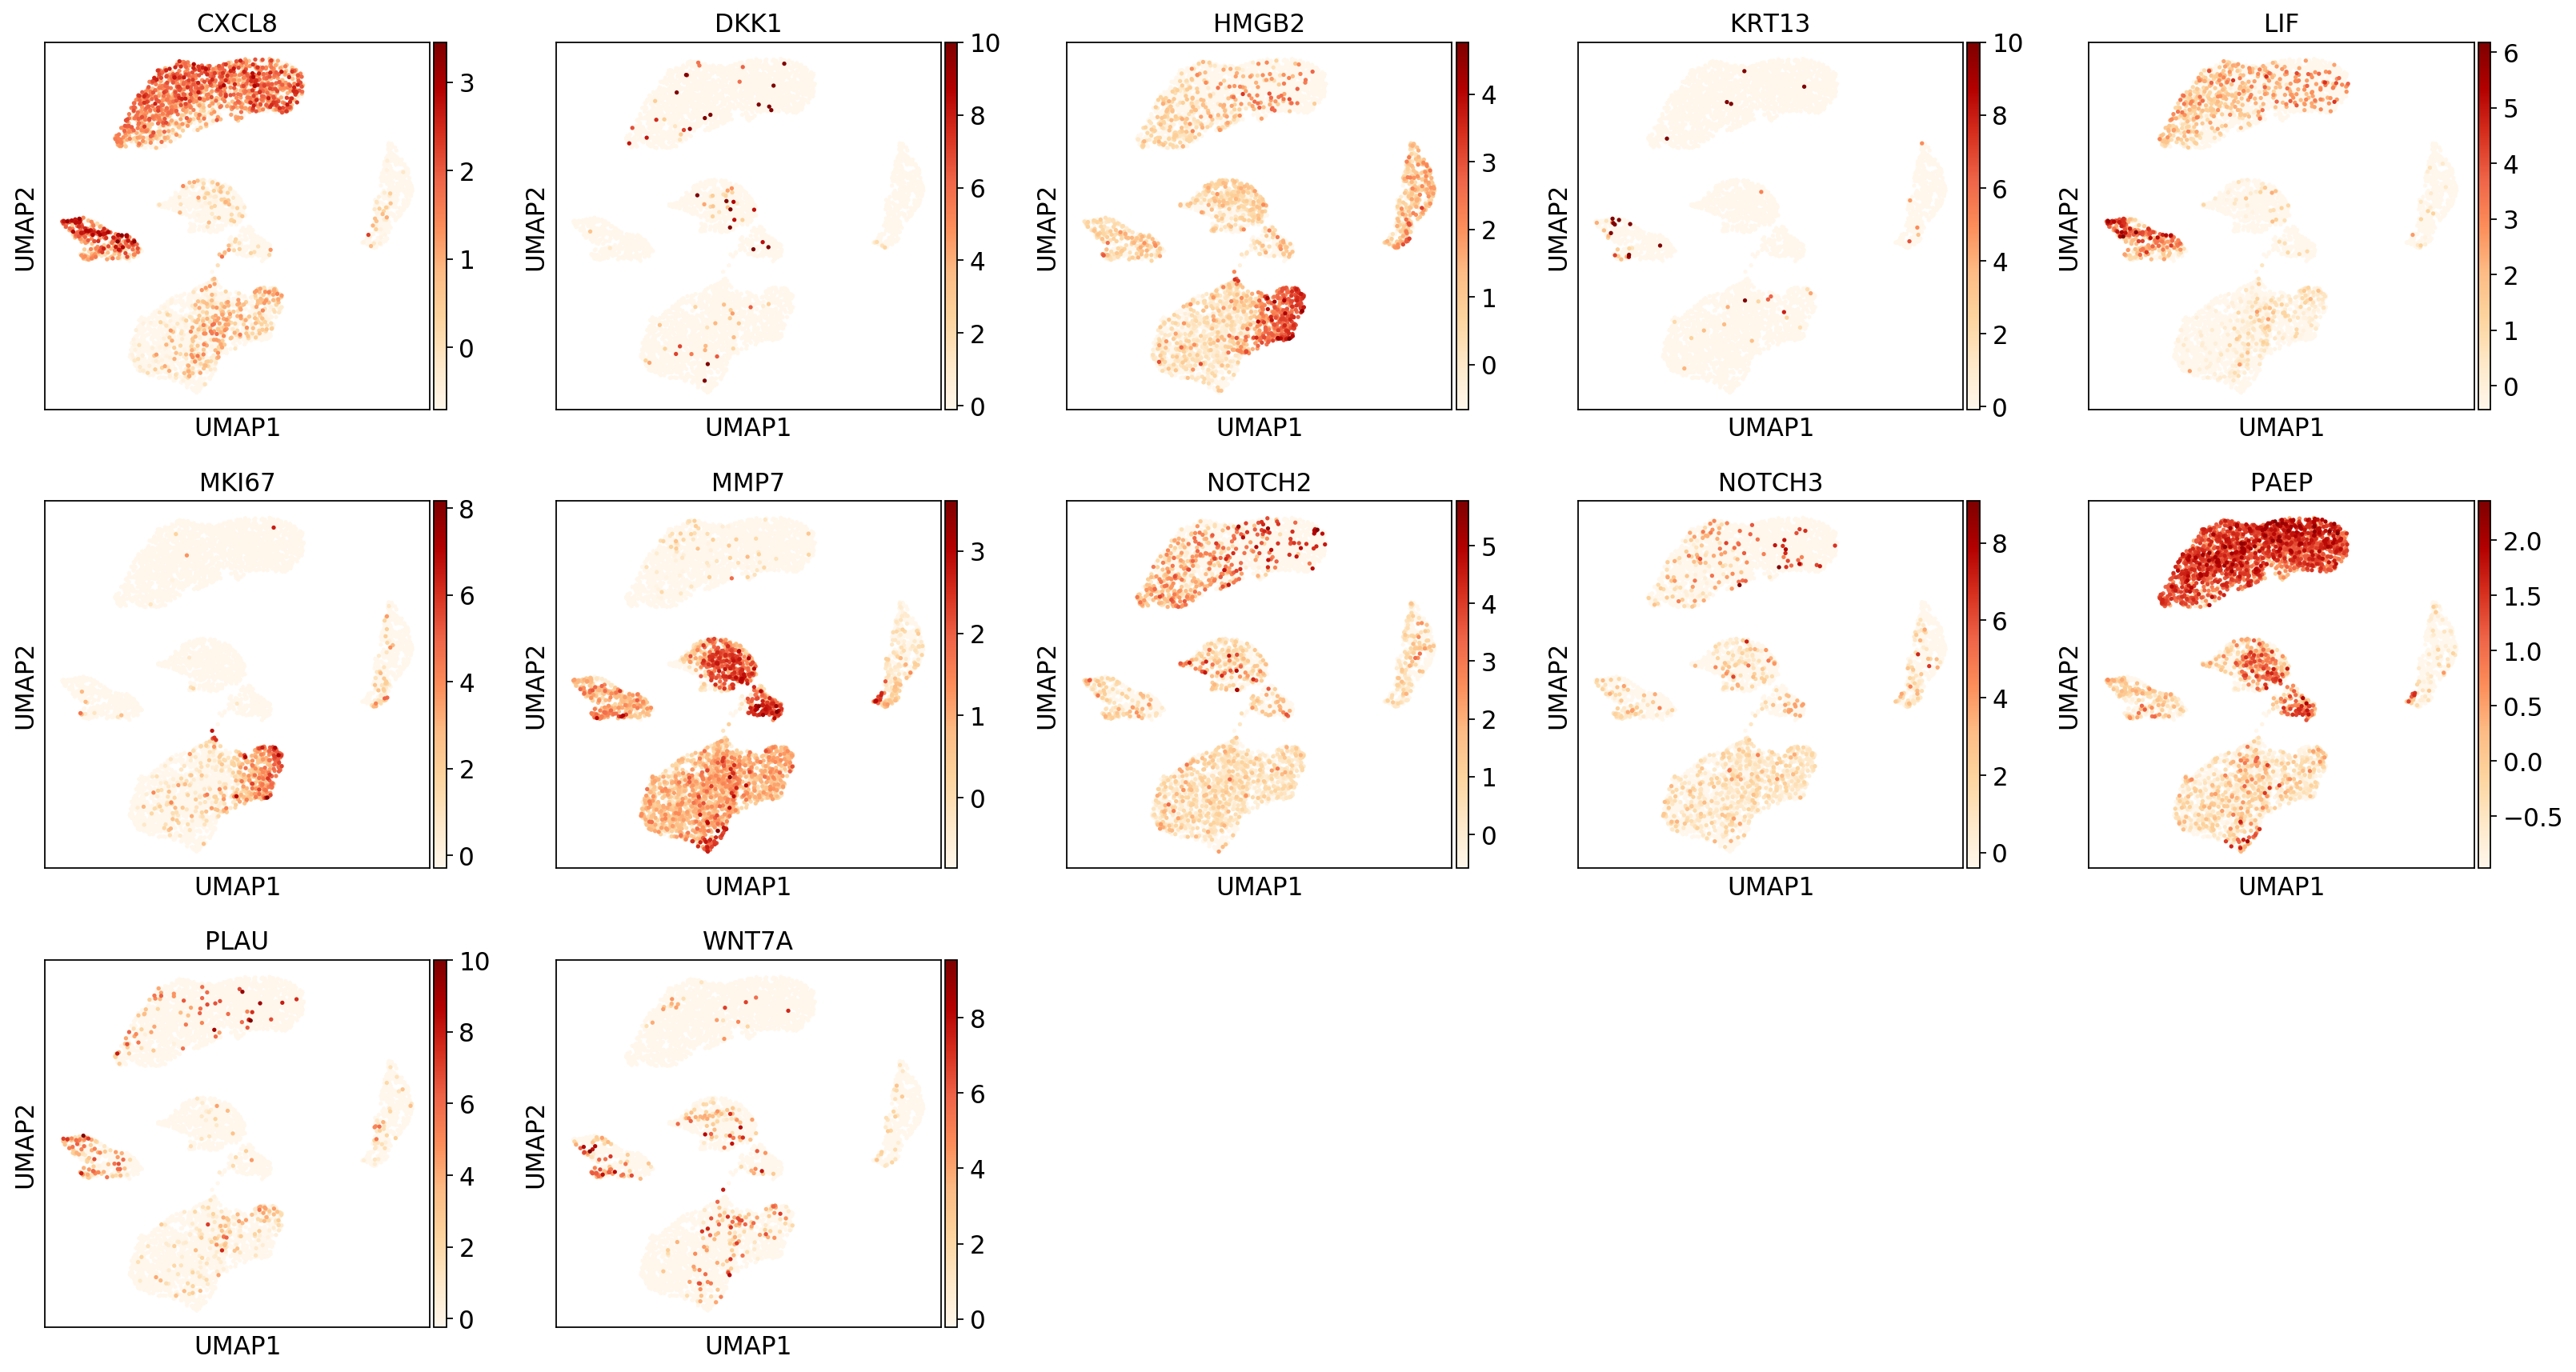

In [121]:
markers = ["HMGB2", "MKI67", "DKK1", "LIF", "CXCL8", "PLAU", "WNT7A", "NOTCH3", "NOTCH2", "MMP7", "PAEP", "KRT13"]
markers = sorted(markers)
sc.pl.umap(adata2plot, color=markers, save='-markers_smFISH.pdf',color_map='OrRd', ncols=5) # FEMALE

## Save

In [122]:
# os.system('rm data/endometrium-N8-epithelial-clean_forSeurat.h5ad')
# adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False)
# adata_count.write('data/endometrium-N8-epithelial-clean_noCiliated_forSeurat.h5ad')

os.system('rm data/endometrium-N8-epithelial-clean_Luzprocessing_freeze.h5ad')
adata.write('data/endometrium-N8-epithelial-clean_Luzprocessing_freeze.h5ad')